In [1]:
import os
os.environ['TF_CPP_MI_LOG_LEVEL'] = '2'
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

In [2]:
# set seed to control randomness: to stop potential
seed = 128
rng = np.random.RandomState(seed)
# root directory settings


In [3]:
# setting root directory
root_dir = os.path.abspath('/home/nil/Documents/av_ml_practise/digit_reco/')
data_dir = os.path.join(root_dir, 'datasets')
sub_dir = os.path.join(root_dir, 'sample_sub')

In [4]:
# check existence
os.path.exists(root_dir)
os.path.exists(data_dir)
os.path.exists(sub_dir)

False

In [5]:
train = pd.read_csv(os.path.join(data_dir, 'train', 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test', 'Test.csv'))
sample_data = pd.read_csv(os.path.join(data_dir,'sample_sub','sample_submission.csv'))

In [6]:
train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


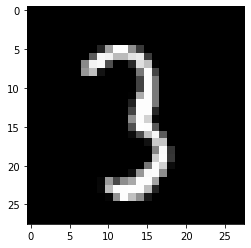

In [7]:
#image display
img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'train', 'Images', 'train', img_name)
img = imread(filepath)
plt.imshow(img);


In [8]:
img

array([[[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       ...,

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0.

In [9]:
temp = []
for img_name in train.filename:
    image_path = os.path.join(data_dir, 'train', 'Images', 'train', img_name)
    img = imread(image_path)
    img = img.astype('float32')
    temp.append(img)
    
train_x = np.stack(temp)

temp = []
for img_name in test.filename:
    image_path = os.path.join(data_dir, 'train', 'Images', 'test', img_name)
    img = imread(image_path)
    img = img.astype('float32')
    temp.append(img)
    
test_x = np.stack(temp)


In [10]:
# to test the proper function, we create validation set
split_size = int(train_x.shape[0]* 0.7)
train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train.label.values[:split_size], train.label.values[split_size:]

In [22]:
def dense_to_one_hot(labels_dense, num_classes = 10):
    """ Convert class label from scalr to one-hot vector """
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels)*num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot


def preproc(unclean_batch_x):
    """ Convert values to range 0-1 """
    temp_batch = unclean_batch_x / unclean_batch_x.max()
    return temp_batch

def batch_creator(batch_size, dataset_length, dataset_name):
    """ Create batch with random samples and return appropiate format"""
    batch_mask = rng.choice(dataset_length, batch_size)
    batch_x = eval(dataset_name + "_x")[[batch_mask]].reshape(-1, input_num_units)
    batch_x = preproc(batch_x)
    if dataset_name == "train":
        batch_y = eval(dataset_name).ix[batch_mask, 'label'].values
        batch_y = dense_to_one_hot(batch_y)
        
    return batch_x, batch_y
    

In [61]:
# set all variables 
# number of neuron in each layer
input_num_units = 28*28
hidden_num_units = 500
output_num_units = 10

# define placeholder
x = tf.placeholder(tf.float32, [None, input_num_units])
y = tf.placeholder(tf.float32, [None, output_num_units])

# set remaining variables
epochs = 5
batch_size = 128
learning_rate = 0.01

# define weights and bias of the neural network
weights = {
    'hidden': tf.Variable(tf.random_normal([input_num_units, hidden_num_units], seed = seed)),
    'output': tf.Variable(tf.random_normal([hidden_num_units, output_num_units], seed = seed))
}

biases = {
    'hidden': tf.Variable(tf.random_normal([hidden_num_units], seed = seed)),
    'output': tf.Variable(tf.random_normal([output_num_units], seed = seed))
}

hidden_layer = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])

hidden_layer = tf.nn.relu(hidden_layer)
output_layer = tf.matmul(hidden_layer, weights['output']) + biases['output']

cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = output_layer, labels =y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

In [62]:
init = tf.global_variables_initializer()

In [63]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = int(train.shape[0]/batch_size)
        for i in range(total_batch):
            batch_x, batch_y = batch_creator(batch_size, train_x.shape[0], 'train')
            #batch_x, batch_y = train_data.next_batch(batch_size)
            _,c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})
            avg_cost += c/total_batch
        print("Epoch: ", (epoch+1), "cost: ", "{:.5f}".format(avg_cost))
    print("Training complete")
    
pred_temp = tf.equal(tf.argmax(output_layer, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(pred_temp, "float"))
print("Validation Accuracy:", 
      accuracy.eval({x: val_x.reshape(-1, input_num_units), y: dense_to_one_hot(val_y)})) 
     
predict = tf.argmax(output_layer, 1)
pred = predict.eval({x: test_x.reshape(-1, input_num_units)})

InvalidArgumentError: Incompatible shapes: [512,10] vs. [128,10]
	 [[node gradients_13/logistic_loss_1/mul_grad/BroadcastGradientArgs (defined at <ipython-input-61-e135f0199990>:33) ]]

Original stack trace for 'gradients_13/logistic_loss_1/mul_grad/BroadcastGradientArgs':
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/nil/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/nil/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/nil/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/nil/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/nil/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/nil/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/nil/.local/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/nil/.local/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/nil/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/nil/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/nil/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/nil/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/nil/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/nil/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/nil/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/nil/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/nil/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/nil/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/nil/.local/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/nil/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/nil/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/nil/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-61-e135f0199990>", line 33, in <module>
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 403, in minimize
    grad_loss=grad_loss)
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 512, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 158, in gradients
    unconnected_gradients)
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py", line 731, in _GradientsHelper
    lambda: grad_fn(op, *out_grads))
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py", line 403, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py", line 731, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py", line 1044, in _MulGrad
    rx, ry = gen_array_ops.broadcast_gradient_args(sx, sy)
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 829, in broadcast_gradient_args
    "BroadcastGradientArgs", s0=s0, s1=s1, name=name)
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()

...which was originally created as op 'logistic_loss_1/mul', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 25 identical lines from previous traceback]
  File "/home/nil/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-61-e135f0199990>", line 32, in <module>
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = output_layer, labels =y))
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py", line 183, in sigmoid_cross_entropy_with_logits
    relu_logits - logits * labels,
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 884, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1180, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 6490, in mul
    "Mul", x=x, y=y, name=name)
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/nil/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()
